# DS 3000 HW 2

Due: Tuesday Oct 10 @ 11:59 PM EST

### Submission Instructions
Submit this `ipynb` file to Gradescope (this can also be done via the assignment on Canvas).  To ensure that your submitted `ipynb` file represents your latest code, make sure to give a fresh `Kernel > Restart & Run All` just before uploading the `ipynb` file to gradescope.

### Tips for success
- Start early
- Make use of Piazza (also accessible through Canvas)
- Make use of Office Hours
- Remember to use cells and headings to make the notebook easy to read (if a grader cannot find the answer to a problem, you will receive no points for it)
- Under no circumstances may one student view or share their ungraded homework or quiz with another student [(see also)](http://www.northeastern.edu/osccr/academic-integrity), though you are welcome to **talk about** (*not* show each other your answers to) the problems.

### Finally:

I designed this homework to provide **less** guidance in each subsequent part; this is on purpose, so that you slowly get used to thinking more critically about how to approach the various tasks. If you are confused as you are working, especially with the later parts, please don't hesitate to reach out for help.

# Part 1: Sunrise-Sunset API

This first part of the homework asks you to complete the pipeline which, given the lattitude / longitude and timezone of some cities:

``` python
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Lusaka': (-15.3875, 28.3228, 'Africa/Lusaka'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}
```

the keys are the `name` of the city and the values are tuples of `lat, lon, timezone_name

is able to:
- query a sunrise / sunset API
- clean and process data (timezone management & building `datetime` objects)
- For extra credit: produce the a graph of daylight through the year like this:

<img src="https://i.ibb.co/CBhWtCY/newdaylight.png" alt="newdaylight" style="width: 500px;"/>

## Part 1.1: Getting Sunrise Sunset via API (5 points)
Write the `get_sunrise_sunset()` function below so that it uses [this sunrise sunset API](https://sunrise-sunset.org/api) to produce the output (the dictionary) shown in the test case below so that it passes the case.

It may be helpful to know that this particular API...
- requires no api key
- returns about 2.5 queries per second
- did not block me when I tried to make 100 consecutive calls as quickly as possible

In [1]:
# make sure you have these modules installed
import requests
import json

In [2]:
def get_sunrise_sunset(lat, lng, date):
    """ retrieves sunrise and sunset data from an api
    
    Args:
        lat (float): latitude of desired location
        lng (float): longitude of desired location
        date (str): desired date formatted as "YYYY-MM-DD"
        
    Returns:
        sun_dict (dict): contains sunrise and sunset data from api
    
    """   
    # build url
    url = f"https://api.sunrise-sunset.org/json?lat={lat}&lng={lng}&date={date}"
    
    # api call
    url_text = requests.get(url).text
    
    # convert into a dict
    sun_dict = json.loads(url_text)
    
    # add info to dict
    sun_dict["lat-lng"] = (lat, lng)
    sun_dict["date"] = date
    
    return sun_dict

In [3]:
sun_dict = get_sunrise_sunset(lat=42.3601, lng=-71.0589, date='2022-02-15')
sun_dict_expected = \
{'results': {'sunrise': '11:38:48 AM',
            'sunset': '10:17:50 PM',
            'solar_noon': '4:58:19 PM',
            'day_length': '10:39:02',
            'civil_twilight_begin': '11:11:30 AM',
            'civil_twilight_end': '10:45:08 PM',
            'nautical_twilight_begin': '10:38:37 AM',
            'nautical_twilight_end': '11:18:00 PM',
            'astronomical_twilight_begin': '10:06:05 AM',
            'astronomical_twilight_end': '11:50:33 PM'},
 'status': 'OK',
 'lat-lng': (42.3601, -71.0589),
 'date': '2022-02-15'}

assert sun_dict == sun_dict_expected, 'get_sunrise_sunset() error'

## Part 1.2 Timezone Considerations: (5 points)

It may appear the test case above works, but a look at the API's documentation reminds us: 

    "NOTE: All times are in UTC and summer time adjustments are not included in the returned data."
    
Meaning that we would need to change the timezone ourself if comparing different locations. 

Complete the `change_tz()` below so that it passes the given test case. 

In [4]:
import pytz
from datetime import datetime

In [5]:
def change_tz(dt, timezone_from, timezone_to):
    """ converts timezone of a timezone naive datetime object
    
    Args:
        dt (datetime): datetime (or time) object without timezone
        timezone_from (str): timezone of input
        timezone_to (str): timezone of output datetime
        
    Returns:
        dt (datetime): datetime object corresponding to 
            unix_time
    """
    dt_from = pytz.timezone(timezone_from).localize(dt)
    
    new_tz = pytz.timezone(timezone_to)
    dt = dt_from.astimezone(new_tz)

    return dt

In [6]:
# build test case input / output
dt_no_tz = datetime(2021, 2, 13, 9, 54, 4, 270088)
dt_expect = datetime(2021, 2, 13, 14, 54, 4, 270088, tzinfo=pytz.timezone('GMT'))

# compute actual output
dt = change_tz(dt_no_tz, timezone_from='US/Eastern', timezone_to='GMT')

assert dt == dt_expect, 'change_tz() error'

In [7]:
# build test case input / output
dt_no_tz = datetime(2021, 2, 13, 9, 54, 4, 270088)
dt_expect = datetime(2021, 2, 13, 9, 54, 4, 270088, tzinfo=pytz.timezone('GMT'))

# compute actual output
dt = change_tz(dt_no_tz, timezone_from='GMT', timezone_to='GMT')

assert dt == dt_expect, 'change_tz() error'

## Part 1.3: Turning the dictionary into a Series (5 points)
Build `clean_sun_dict()` to pass each of the two test cases below.  Note that:
- sunrise and sunset are `time` objects which account for daylight's saving:
    - include the date when building these objects
    - use `change_tz()` above to cast them to the proper timezone
    - build `time` objects by calling `datetime.time()` to discard the date of a `datetime`
    - importing `pandas as pd` and using `pd.to_datetime` may also be helpful
- `sunrise_hr` and `sunset_hr` are the hours since the day began in local timezone (more easily graphed)
    - you may use `.strftime()` and `int()` to cast time objects to strings and then integers (which may be helpful) 
    
**NOTE:** There may be more than one way to accomplish writing this function; as long as the function passes both `assert` test cases, you may continue. Just do be sure to comment and present your code as cleanly as possible. **NOTE ALSO** that because of the way *I* made the solution, the `sunrise_hr` and `sunset_hr` values are rounded strangely. If you are getting something *close*, you **may** change the test case to match your so that the `assert` works.

In [2]:
from datetime import datetime, time
import pandas as pd

In [45]:
def clean_sun_dict(sun_dict, timezone_to):
    """ builds pandas series and cleans output of API
    
    Args:
        sun_dict (dict): dict of json (see ex below)
        timezone_to (str): timezone of outputs (API returns
            UTC times)
            
    Returns:
        sun_series (pd.Series): all times converted to
            time objects
    
    example sun_series:
    
    date            2021-02-13 00:00:00
    lat-lng        (36.72016, -4.42034)
    sunrise                    02:11:06
    sunrise_hr                    2.185
    sunset                     13:00:34
    sunset_hr                   13.0094
    dtype: object
    """
    clean_sun_dict = dict({})
    
    # clean date
    date = sun_dict["date"]
    clean_date = datetime.strptime(date, "%Y-%m-%d")
    
    clean_sun_dict["date"] = clean_date
    
    # clean lat-lng
    clean_sun_dict["lat-lng"] = sun_dict["lat-lng"]
    
    # clean and convert sunrise
    sunrise = sun_dict["results"]["sunrise"]
    stripped_time = datetime.strptime(sunrise, "%I:%M:%S %p")
    converted_time = change_tz(stripped_time, "UTC", timezone_to)
    sunrise_time = converted_time.time()
    
    clean_sun_dict["sunrise"] = sunrise_time
    
    # compute sunrise hr
    total_seconds = ((sunrise_time.minute * 60) + sunrise_time.second) / 3600
    elapsed = sunrise_time.hour + total_seconds
    
    clean_sun_dict["sunrise_hr"] = elapsed
    
    # clean and convert sunset
    sunset = sun_dict["results"]["sunset"]
    stripped_time = datetime.strptime(sunset, "%I:%M:%S %p")
    converted_time = change_tz(stripped_time, "UTC", timezone_to)
    sunset_time = converted_time.time()
    
    clean_sun_dict["sunset"] = sunset_time
    
    # compute sunset hr
    total_seconds = ((sunset_time.minute * 60) + sunset_time.second) / 3600
    elapsed = sunset_time.hour + total_seconds
    
    clean_sun_dict["sunset_hr"] = elapsed
    
    # create series
    sun_series = pd.Series(clean_sun_dict)
    return sun_series

In [46]:
sun_dict = {'results': {'sunrise': '11:38:48 AM',
                        'sunset': '10:17:50 PM',
                        'solar_noon': '4:58:19 PM',
                        'day_length': '10:39:02',
                        'civil_twilight_begin': '11:11:30 AM',
                        'civil_twilight_end': '10:45:08 PM',
                        'nautical_twilight_begin': '10:38:37 AM',
                        'nautical_twilight_end': '11:18:00 PM',
                        'astronomical_twilight_begin': '10:06:05 AM',
                        'astronomical_twilight_end': '11:50:33 PM'},
             'status': 'OK',
             'lat-lng': (42.3601, -71.0589),
             'date': '2022-02-15'}

# test without timezone conversion
sun_series = clean_sun_dict(sun_dict, timezone_to='GMT')

sun_series_exp = pd.Series(
{'date': datetime(year=2022, month=2, day=15),
'lat-lng': (42.3601, -71.0589),
'sunrise': time(hour=11, minute=38, second=48),
'sunrise_hr': 11.646666666666667,
'sunset': time(hour=22, minute=17, second=50),
'sunset_hr': 22.29722222222222})

assert sun_series.eq(sun_series_exp).all(), 'clean_sun_dict() error (GMT)'

In [47]:
# test with timezone conversion
sun_series = clean_sun_dict(sun_dict, timezone_to='US/Eastern',)

sun_series_exp = pd.Series(
{'date': datetime(year=2022, month=2, day=15),
'lat-lng': (42.3601, -71.0589),
'sunrise': time(hour=6, minute=42, second=48),
'sunrise_hr': 6.713333333333333,
'sunset': time(hour=17, minute=21, second=50),
'sunset_hr': 17.363888888888887})

assert sun_series.eq(sun_series_exp).all(), 'clean_sun_dict() error (EST)'

## Part 1.4: Getting our Data Frame (5 points)

Write the `get_annual_sun_data()` function so that it produces the outputs shown below.  This function should make use of:
 - `get_sunrise_sunset()`
 - `clean_sun_dict()`
   
as built above. I will start the function for you to help!

The following snippet:

```python
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Lusaka': (-15.3875, 28.3228, 'Africa/Lusaka'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}
df_annual_sun = get_annual_sun_data(loc_dict, year=2021, period_day=30)
df_annual_sun.head(6)
```

should generate:

|    |   city |       date |              lat-lng |  sunrise | sunrise_hr |   sunset | sunset_hr |
|---:|-------:|-----------:|---------------------:|---------:|-----------:|---------:|----------:|
|  0 | Boston | 2021-01-01 |  (42.3601, -71.0589) | 07:11:49 |   7.196944 | 16:24:12 | 16.403333 |
|  1 | Lusaka | 2021-01-01 |  (-15.3875, 28.3228) | 05:38:33 |   5.642500 | 18:42:09 | 18.702500 |
|  2 | Sydney | 2021-01-01 | (-33.8688, 151.2093) | 05:46:24 |   5.773333 | 20:10:53 | 20.181389 |
|  3 | Boston | 2021-01-31 |  (42.3601, -71.0589) | 06:56:43 |   6.945278 | 16:58:42 | 16.978333 |
|  4 | Lusaka | 2021-01-31 |  (-15.3875, 28.3228) | 05:55:43 |   5.928611 | 18:44:35 | 18.743056 |
|  5 | Sydney | 2021-01-31 | (-33.8688, 151.2093) | 06:14:24 |   6.240000 | 20:02:42 | 20.045000 |

In [64]:
# could be useful
from datetime import timedelta

In [71]:
def get_annual_sun_data(loc_dict, year=2021, period_day=30): 
    """ pulls evenly spaced sunrise / sunsets from API over year per city
    
    Args:
        loc_dict (dict): keys are cities, values are tuples of 
            (lat, lon, tz_str) where tz_str is a timezone
            string included in pytz.all_timezones
        year (int): year to query
        period_day (int): how many days between data queries
            (i.e. period_day=1 will get every day for the year)
            
    Returns:
        df_annual_sun (DataFrame): each row represents a 
            sunrise / sunset datapoint, see get_sunrise_sunset()
    """
    cycle_day = pd.to_datetime(f'{year}-01-01')
    cycle_city = loc_dict.keys()
    df_annual_sun = pd.DataFrame()
    
    while cycle_day.year == year:
        for city in cycle_city:
            city_series = pd.Series({'city': city})
            
            date = cycle_day.strftime("%Y-%m-%d")
            sun_dict = get_sunrise_sunset(loc_dict[city][0], loc_dict[city][1], date)
            sun_series = clean_sun_dict(sun_dict, loc_dict[city][2])
            
            city_series = pd.concat([city_series, sun_series])
            df_annual_sun = pd.concat([df_annual_sun, city_series.to_frame().T])

        cycle_day = cycle_day + timedelta(days = period_day)

    return df_annual_sun

In [73]:
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Lusaka': (-15.3875, 28.3228, 'Africa/Lusaka'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}

# you may find that setting period_day to a larger value is quicker for debug
# period_day=5 takes about a minute or so given the API does 2-3 requests / sec
df_annual_sun = get_annual_sun_data(loc_dict, year=2021, period_day=30)

## Part 1.5: Plotting the data (5 points)

Using [plt.fillbetween()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.fill_between.html), like [this example](https://colab.research.google.com/drive/1eYuuwGwQKEa6x84fqpdVlf46sXLDmhCZ?usp=sharing), write the `plot_daylight()` function so that:

``` python
plot_daylight(df_annual_sun)
```

produces a similar graph to:

<img src="https://i.ibb.co/CBhWtCY/newdaylight.png" alt="newdaylight" style="width: 500px;"/>

Be sure that your graph displays in Jupyter notebook (no need to save it in another form).

In [74]:
# modules you might use
import seaborn as sns
import matplotlib.pyplot as plt

In [89]:
sns.set(font_scale=1.2)

def plot_daylight(df_annual_sun):
    """ produces a plot of daylight seen across cities
    
    Args:
        df_annual_sun (DataFrame): each row represents a 
            sunrise / sunset datapoint, see get_sunrise_sunset()
    """
    for city in ["Boston", "Lusaka", "Sydney"]:
        x = []
        y1 = []
        y2 = []
        
        for index, row in df_annual_sun.iterrows():
            if row["city"] == city:
                x.append(row["date"])
                y1.append(row["sunrise_hr"])
                y2.append(row["sunset_hr"])
        
        plt.fill_between(x, y1, y2, alpha = .4, label = city)
    
    plt.title("daylight at each location")
    plt.xlabel("date")
    plt.ylabel("local military time")
    plt.legend()
    plt.show()

In [91]:
# takes about a minute to run with period_day=7, worth the wait to characterize
# the sudden jumps due to daylight savings times
df_annual_sun = get_annual_sun_data(loc_dict, year=2021, period_day=7)

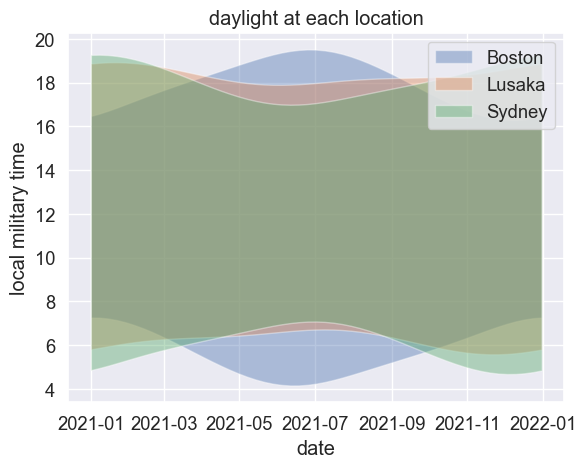

In [92]:
plot_daylight(df_annual_sun)

# Part 2: Spotify API (Spotipy)

**Note**: The following is copied verbatim from the end of Day2_APIs on Canvas.

The Spotify API is quite powerful and gives us access to any song/artist in its libraries, plus even more information that you might not have thought of. There is also a module that has been created to access the API within python. Open up a terminal (or do it in jupyter notebook; this is a magic module) and run:

`pip install spotipy`

In [16]:
# after installation
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

Just like with OpenWeather, we need to make an account [here](https://developer.spotify.com/) (this is essentially the same as making a regular Spotify account) and then get an API key (Spotify requires two things, actually, a Client ID and a secret key). At the above website, go to:

- Dashboard
- Log into your Spotify account (make one if you don't have one)
- Accept the terms of using the API
- Create an app (you can call it anything, I called mine `DS3000_Spotify`)
- Get a client ID (mine is `592acf2d2dc84d94bbc652f2f1d72375`, though it is usually good practice to **not** share this) and a client secret (**never share this with anyone**: save it in a separate file like we did with our OpenWeather API key earlier)

There exists a file `spotify_secret.py` in same directory as this jupyter notebook which contains:
    
    secret = 'professorgerberssecretspotify'

In [21]:
# make sure you have named your file spotify_secret.py
from spotify_secret import secret

In [22]:
# Authentication
# Make sure you use your OWN client ID (DO NOT leave mine in there!!)
cid = '585ed639249a495fa4d02d56d05a6c9f'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## Part 2.1: Uniform Resource Identifiers (URI) (5 points)

An important component of using the Spotify API is the use of the uniform resource identifiers, pointing at each object in the API. We need a URI to perform any function with the API referring to an object in Spotify. The URI of any Spotify object is contained in its shareable link. For example, the link to the Global top songs playlist, when found from the Spotify desktop application, is:

In [42]:
# if you receive a couldn't read cache or write token error, it should simply be a warning and not be a problem
playlist_link = "https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

In [44]:
# take a look at a single track from the playlist
# it is commented out because it will produce a lot of output! You can uncomment it out to see what it looks like.

# sp.playlist_tracks(playlist_URI)["items"][0]

On the Getting to Know You form, I asked what the theme song for the TV show of your life would be. Below is the url for the Spotify playlist created from those songs. Read it into python the way we did the above playlist.

`playlist_link = "https://open.spotify.com/playlist/6Bl2siSxFI0mmdzOwy562o"`

In [140]:
playlist_link = "https://open.spotify.com/playlist/6Bl2siSxFI0mmdzOwy562o"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

## Part 2.2: Build a dictionary of track info (5 points)

I have initialized the `playlist_dict` dictionary for you below, complete with keys and empty lists. Use a for loop to loop through the tracks in our class's playlist and `.append()` the associated values for each track to each of the lists, building out the dictionary. You may write a function to do this, but you don't have to. **Note**: if you know of a faster way to do this than with a for loop, you are welcome to use it.

In [62]:
playlist_dict = {'track_uri': list(),
                'track_name': list(),
                'artist_uri': list(),
                'artist_name': list(),
                'artist_pop': list(),
                'artist_genres': list(),
                'album': list(),
                'track_pop': list()}

In [100]:
for song in sp.playlist_tracks(playlist_URI)["items"]:
    playlist_dict["track_uri"].append(song["track"]["uri"])
    
    playlist_dict["track_name"].append(song["track"]["name"])
    
    artist_uri = song["track"]["artists"][0]["uri"]
    playlist_dict["artist_uri"].append(artist_uri)
    
    playlist_dict["artist_name"].append(song["track"]["artists"][0]["name"])
    
    playlist_dict["artist_pop"].append(sp.artist(artist_uri)["popularity"])
    
    playlist_dict["artist_genres"].append(sp.artist(artist_uri)["genres"])
    
    playlist_dict["album"].append(song["track"]["album"]["name"])
    
    playlist_dict["track_pop"].append(song["track"]["popularity"])

## Part 2.3: Extracting Features from Tracks (5 points)

Now that we have a list of track URIs, we can extract features from these tracks. Spotify has a list of these features for each of its tracks, from analysis of the audio. We can access these with a single method of the spotify object `audio_features(uri)`. This gives us a list of mostly numerical features that we can use for analysis.

In [165]:
# note that .audio_features returns a dictionary in a list of 1
sp.audio_features(playlist_dict['track_uri'][0])

[{'danceability': 0.631,
  'energy': 0.605,
  'key': 0,
  'loudness': -8.73,
  'mode': 1,
  'speechiness': 0.0386,
  'acousticness': 0.453,
  'instrumentalness': 0.000184,
  'liveness': 0.291,
  'valence': 0.25,
  'tempo': 115.281,
  'type': 'audio_features',
  'id': '4LVDnRxfljiEerC26z3JW4',
  'uri': 'spotify:track:4LVDnRxfljiEerC26z3JW4',
  'track_href': 'https://api.spotify.com/v1/tracks/4LVDnRxfljiEerC26z3JW4',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4LVDnRxfljiEerC26z3JW4',
  'duration_ms': 295293,
  'time_signature': 4}]

I have initiated an empty `song_dict` for you below. Loop through the track URIs of our `playlist_dict` from the previous part then for each song, loop through the audio features and add corresponding key-value pairs to the dictionary. Finally, after you have created the dictionary, cast it to a Data Frame called `song_df` using pandas. **Note**: if you know of a faster way to do this than with a nested for loop, you are welcome to use it.

In [272]:
from collections import defaultdict
import pandas as pd

song_dict = {'danceability': [],
             'energy': [],
             'key': [],
             'loudness': [],
             'mode': [],
             'speechiness': [],
             'acousticness': [],
             'instrumentalness': [],
             'liveness': [],
             'valence': [],
             'tempo': [],
             'type': [],
             'id': [],
             'uri': [],
             'track_href': [],
             'analysis_url': [],
             'duration_ms': [],
             'time_signature': []}

In [273]:
for song in playlist_dict["track_uri"]:
    audio_feats = sp.audio_features(song)[0]
    for key, value in audio_feats.items():
        song_dict[key].append(value)

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=4ZPdLEztrlZqbJkgHNw54L:
 Max Retries, reason: too many 429 error responses

In [274]:
song_df = pd.DataFrame.from_dict(song_dict)

In [277]:
# uncomment the below to see if you completed your task
song_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.631,0.605,0,-8.730,1,0.0386,0.45300,0.000184,0.2910,0.250,115.281,audio_features,4LVDnRxfljiEerC26z3JW4,spotify:track:4LVDnRxfljiEerC26z3JW4,https://api.spotify.com/v1/tracks/4LVDnRxfljiE...,https://api.spotify.com/v1/audio-analysis/4LVD...,295293,4
1,0.531,0.766,8,-7.692,1,0.0582,0.00560,0.000000,0.2010,0.532,130.048,audio_features,1rS3J4u1G8f6hbmTosa8Nf,spotify:track:1rS3J4u1G8f6hbmTosa8Nf,https://api.spotify.com/v1/tracks/1rS3J4u1G8f6...,https://api.spotify.com/v1/audio-analysis/1rS3...,179493,4
2,0.561,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,audio_features,4uUG5RXrOk84mYEfFvj3cK,spotify:track:4uUG5RXrOk84mYEfFvj3cK,https://api.spotify.com/v1/tracks/4uUG5RXrOk84...,https://api.spotify.com/v1/audio-analysis/4uUG...,175238,4
3,0.620,0.712,9,-6.434,1,0.1000,0.22800,0.000003,0.0561,0.830,170.234,audio_features,4dRqYKhLVujxiBXcq50YzG,spotify:track:4dRqYKhLVujxiBXcq50YzG,https://api.spotify.com/v1/tracks/4dRqYKhLVujx...,https://api.spotify.com/v1/audio-analysis/4dRq...,268600,4
4,0.787,0.655,6,-8.339,0,0.0431,0.23800,0.000171,0.1380,0.650,102.485,audio_features,6shRGWCtBUOPFLFTTqXZIC,spotify:track:6shRGWCtBUOPFLFTTqXZIC,https://api.spotify.com/v1/tracks/6shRGWCtBUOP...,https://api.spotify.com/v1/audio-analysis/6shR...,208653,4


## Part 2.4: Cleaning/manipulating (5 points)

Look at the information in `playlist_dict` and the information in `song_df`. What information would you like to add to `song_df` from `playlist_dict`? What information is in `song_df` that is not very useful?

**Briefly discuss** your answers to those two questions in a markdown cell, then make the changes to `song_df`. That is: add the columns to the Data Frame that you wish to add, and delete the columns that are not useful. Keep in mind that there are many "correct" answers here.

From playlist_dict, I think it would be useful to add track name and artist name to the dataframe. It would be okay to remove the type column, id, uri, track_href, and analysis_url.

In [283]:
song_df = song_df.drop(["type", "id", "uri", "track_href", "analysis_url"], axis = 1)

song_df["track_name"] = playlist_dict["track_name"][:197]
song_df["artist_name"] = playlist_dict["artist_name"][:197]

song_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_name,artist_name
0,0.631,0.605,0,-8.730,1,0.0386,0.45300,0.000184,0.2910,0.250,115.281,295293,4,Pursuit Of Happiness (nightmare),Kid Cudi
1,0.531,0.766,8,-7.692,1,0.0582,0.00560,0.000000,0.2010,0.532,130.048,179493,4,I Found A Way,Drake Bell
2,0.561,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,175238,4,I'm Good (Blue),David Guetta
3,0.620,0.712,9,-6.434,1,0.1000,0.22800,0.000003,0.0561,0.830,170.234,268600,4,This Life,Vampire Weekend
4,0.787,0.655,6,-8.339,0,0.0431,0.23800,0.000171,0.1380,0.650,102.485,208653,4,Upside Down,Jack Johnson


## Part 2.5: Plotting (5 points)

Using plotly, make two plots (in separate code cells):
- of energy (x-axis) versus danceability (y-axis) that has the song title as hover data.
- of acousticness (x-axis) versus loudness (y-axis) that has the song title as hover data.

**Then**, in a markdown cell, discuss the relationships (if any) you see in these plots and whether those relationships make sense to you/what you would have expected to see.

In [284]:
import plotly.express as px

In [285]:
fig = px.scatter(song_df, x = "energy", y = "danceability", hover_data = ["track_name"], title = "energy vs. danceability")
fig

In [287]:
fig = px.scatter(song_df, x = "acousticness", y = "loudness", hover_data = ["track_name"], 
                 title = "acousticness vs. loudness")
fig

The plot for energy vs. danceability has a weak upwards trend. This makes sense to me as higher energy would seem to imply that the song is easier to dance to. However, I expected a stronger correlation between the two variables. For the plot on acousticness vs. loudness, it seems there is a downwards trend. I'm not sure I expected this as I would assume that songs with higher acousticness would be louder. 

# Part 3: Web Scraping Fantasy Football

## Part 3.1: Get a table (5 points)

In Fantasy Football, real NFL players gain points for fans at home based on some scoring criteria (which differs based on the website, but in all cases more points is better). Use the `pd.read_html` function to pull in the table located at the following url from Week 1 of current Yahoo Fantasy Football season: https://football.fantasysports.yahoo.com/f1/whoshot?pos=ALL&week=1

In [221]:
table = pd.read_html("https://football.fantasysports.yahoo.com/f1/whoshot?pos=ALL&week=1")

## Part 3.2: Build a clean Data Frame (10 points)

Write a function `clean_nfl_df()` which takes the table from Part 3.1 as input and :

- breaks up the `Name` column into three columns: `Name`, `Team`, `Pos` (position). For example, the first couple observations under the `Name` column as it is read in by default should be:

| Name                                                      |
|----------------------------------------------------------:|
| New Player Note  Tyreek Hill Mia - WR Final W 36-34 @ LAC |
| No new player Notes Dallas Dal - DEF Final W 40-0 @ NYG   |

    this should be replaced with three columns:

| Name             | Team | Pos |
|-----------------:|-----:|----:|
| Tyreek Hill      | Mia  | WR  |
| Dallas           | Dal  | DEF |

- breaks up the `Stats` column into different numeric columns based on the statistics. There should be:
    * `Pass Yds`
    * `Rec Yds`
    * `Rush Yds`
    * `Pass TD`
    * `Rec TD`
    * `Rush TD`
    * `Rec`
    * `Sack`
    * `Int`
    * `Fum Rec`
    
    so that the first couple observations:
    
| Stats                               |
|------------------------------------:|
| 11 Rec, 215 Rec Yds, 2 Rec TD       |
| 7 Sack, 2 Int, 1 Fum Rec            |

    becomes
    
| Pass Yds | Rec Yds | Rush Yds | Pass TD | Rec TD | Rush TD | Rec | Sack | Int | Fum Rec |
|---------:|--------:|---------:|--------:|-------:|--------:|----:|-----:|----:|--------:|
|   NaN    |  215    |    NaN   |   NaN   | 2      | NaN     | 11  | NaN  | NaN | NaN     |
|   NaN    |  NaN    |    NaN   |   NaN   | NaN    | NaN     | NaN | 7    | 2   | 1       |

- produces the final clean data frame whose first two rows look like:

| Name             | Team | Pos | Pass Yds | Rec Yds | Rush Yds | Pass TD | Rec TD | Rush TD | Rec | Sack | Int | Fum Rec | Fan Pts   |
|-----------------:|-----:|----:|---------:|--------:|---------:|--------:|-------:|--------:|----:|-----:|----:|--------:|----------:|
| Tyreek Hill      | Mia  | WR  |   NaN    |  215    |    NaN   |   NaN   | 2      | NaN     | 11  | NaN  | NaN | NaN     | 39.00 |
| Dallas           | Dal  | DEF |   NaN    |  NaN    |    NaN   |   NaN   | NaN    | NaN     | NaN | 7    | 2   | 1       | 37.00 |

In [219]:
def clean_nfl_df(table):
    """ cleans a table of NFL Fantasy Football data
    
    Args:
        table (list): a list of tables scraped from the website
    
    Returns:
        df_fantasy (pd.DataFrame): a clean dataframe with the info from the table
    """
    
    df_fantasy = pd.DataFrame()
    
    for index, row in table[0].iterrows():
        row_dict = dict({})
        
        name_str = row["Name"].split("-")
        left = name_str[0].split(" ")
        mid = name_str[1].split(" ")
    
        row_dict["Name"] = (left[-4] + " " + left[-3]).strip()
        row_dict["Team"] = left[-2]
        row_dict["Pos"] = mid[1]
        
        stat_str = row["Stats"].split(",")
        for stat in stat_str:
            if "Pass Yds" in stat:
                stat = stat.replace("Pass Yds", "").strip()
                row_dict["Pass Yds"] = int(stat)
                continue
            if "Rec Yds" in stat:
                stat = stat.replace("Rec Yds", "").strip()
                row_dict["Rec Yds"] = int(stat)
                continue
            if "Rush Yds" in stat:
                stat = stat.replace("Rush Yds", "").strip()
                row_dict["Rush Yds"] = int(stat)
                continue
            if "Pass TD" in stat:
                stat = stat.replace("Pass TD", "").strip()
                row_dict["Pass TD"] = int(stat)
                continue
            if "Rec TD" in stat:
                stat = stat.replace("Rec TD", "").strip()
                row_dict["Rec TD"] = int(stat)
                continue
            if "Rush TD" in stat:
                stat = stat.replace("Rush TD", "").strip()
                row_dict["Rush TD"] = int(stat)
                continue
            if "Fum Rec" in stat:
                stat = stat.replace("Fum Rec", "").strip()
                row_dict["Fum Rec"] = int(stat)
                continue
            if "Rec" in stat:
                stat = stat.replace("Rec", "").strip()
                row_dict["Rec"] = int(stat)
                continue
            if "Sack" in stat:
                stat = stat.replace("Sack", "").strip()
                row_dict["Sack"] = int(stat)
                continue
            if "Int" in stat:
                stat = stat.replace("Int", "").strip()
                row_dict["Int"] = int(stat)
                
        row_dict["Fan Pts"] = row["Fan Pts"]
        
        row_series = pd.Series(row_dict)
        df_fantasy = pd.concat([df_fantasy, row_series.to_frame().T])
        
    return df_fantasy

In [220]:
df_fantasy = clean_nfl_df(table)
df_fantasy

,Name,Team,Pos,Rec,Rec Yds,Rec TD,Fan Pts,Sack,Int,Fum Rec,Pass Yds,Pass TD,Rush Yds,Rush TD
0,Tyreek Hill,Mia,WR,11,215,2,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Dallas,Dal,DEF,NaN,NaN,NaN,37.0,7,2,1,NaN,NaN,NaN,NaN
0,Brandon Aiyuk,SF,WR,8,129,2,28.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Tua Tagovailoa,Mia,QB,NaN,NaN,NaN,28.14,NaN,1,NaN,466,3,NaN,NaN
0,Aaron Jones,GB,RB,2,NaN,NaN,25.7,NaN,NaN,NaN,NaN,NaN,41,1
0,Mac Jones,NE,QB,NaN,NaN,NaN,25.14,NaN,1,NaN,316,3,NaN,NaN
0,Jakobi Meyers,LV,WR,9,81,2,24.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Austin Ekeler,LAC,RB,4,NaN,NaN,24.4,NaN,NaN,NaN,NaN,NaN,117,1
0,Christian McCaffrey,SF,RB,3,NaN,NaN,24.4,NaN,NaN,NaN,NaN,NaN,152,1
0,Jordan Love,GB,QB,NaN,NaN,NaN,23.0,NaN,NaN,NaN,245,3,12,NaN


### Part 3.3: More Cleaning (5 points)

Go to the url from Part 2.1 in the browser and examine how the url changes when different positions or weeks are selected. Then, write the function `weekly_nfl_df()` which takes two arguments `pos` and `week`, and which uses your `clean_nfl_df()` function from Part 2.1 to produce a clean data frame for any position and any week (depending on when you complete this, there have only been 2-5 weeks so far; thus when you test this function only use 1 or 2 to be safe).

In [223]:
def weekly_nfl_df(pos, week):
    """ returns a clean dataframe for any position and any week
    
    Args:
        pos (str): desired position ("ALL", "QB" ...)
        week (str): desired week (1-5)
        
    Returns:
        df_fantasy (pd.DataFrame): a clean dataframe for the table on the page with the given parameters
    
    """
    url = f"https://football.fantasysports.yahoo.com/f1/whoshot?pos={pos}&week={week}"
    table = pd.read_html(url)
    
    df_fantasy = clean_nfl_df(table)
    return df_fantasy

In [224]:
df_fantasy = weekly_nfl_df("QB", "2")
df_fantasy.head()

,Name,Team,Pos,Pass Yds,Pass TD,Int,Fan Pts,Rush Yds,Rush TD
0,Daniel Jones,NYG,QB,321,2,1,31.74,NaN,NaN
0,Kirk Cousins,Min,QB,364,4,NaN,28.56,NaN,NaN
0,Russell Wilson,Den,QB,308,3,1,26.92,NaN,NaN
0,Jalen Hurts,Phi,QB,193,1,1,26.22,NaN,NaN
0,Joshua Dobbs,Ari,QB,228,1,NaN,25.22,41,NaN


### Part 3.4: Using the function (5 points)

Use your `weekly_nfl_df()` function from Part 2.3 to create a single data frame that includes the top fantasy Quarterbacks (`pos = 'QB'`) for the first 3 weeks of this season. **Note**: there may be multiple ways to do this, and you **must** wait until the morning of September 26 to be able to do all three weeks.

In [226]:
week1 = weekly_nfl_df("QB", "1")
week2 = weekly_nfl_df("QB", "2")
week3 = weekly_nfl_df("QB", "3")

df_qb = pd.concat([week1, week2, week3])
df_qb

,Name,Team,Pos,Pass Yds,Pass TD,Int,Fan Pts,Rush Yds,Rec,Rush TD
0,Tua Tagovailoa,Mia,QB,466,3,1,28.14,NaN,NaN,NaN
0,Mac Jones,NE,QB,316,3,1,25.14,NaN,NaN,NaN
0,Jordan Love,GB,QB,245,3,NaN,23.0,12,NaN,NaN
0,Anthony Richardson,Ind,QB,223,1,1,21.92,NaN,NaN,NaN
0,Deshaun Watson,Cle,QB,154,1,1,21.66,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
0,Matthew Stafford,LAR,QB,269,1,2,13.46,NaN,NaN,NaN
0,Mac Jones,NE,QB,201,1,NaN,13.34,13,NaN,NaN
0,Gardner Minshew,Ind,QB,227,1,NaN,13.08,NaN,NaN,NaN
0,Justin Fields,Chi,QB,99,1,1,11.66,NaN,NaN,NaN


### Part 3.5: Plotting and Interpretation (5 points)

Make a graph which plots `Pass Yds` on the x-axis against `Fan Pts` on the y-axis, and colors the points based on `Pass TD`. Use `plotly` and include the `Name` and `Team` as `hover_data`. Make sure the graph is well labeled, titled, and includes a legend. Then, in a Markdown cell, discuss in **at least 3** sentences your interpretation of the graph.

- **Note**: if you are not an american football fan, in brief the Quarterback's role is to throw the ball to other players in the hopes of scoring a touchdown (if you want a much more technical description, you may also read a bit [here](https://en.wikipedia.org/wiki/Quarterback)).

In [227]:
import plotly.express as px

In [229]:
fig = px.scatter(df_qb, x = "Pass Yds", y = "Fan Pts", color = "Pass TD", 
                 hover_data = ["Name", "Team"], title = "Quarterback Stats")

fig.show()

This graph shows pass yards mapped to fantasy points. There seems to be an upward trend, implying that higher pass yards are correlated with higher fantasy points. The graph also seems to depict that, although there is some overlap, passing touchdown does have an effect on where each grouping is placed, seeing as lower scores are shown lower on the graph and vice versa.

### Part 3.6: More Plotting and Interpretation(5 points)

Use the `weekly_nfl_df()` function to create data frames for each of the four main offensive positions (QB, WR, RB, TE) **for the first four weeks** and then create, using subplots in a single plot, histograms for each positions' `Fan Pts`. Make sure the subplots are on the same scale, well labeled, and titled. Discuss the results in a few short sentences.

In [230]:
qb_week1 = weekly_nfl_df("QB", "1")
qb_week2 = weekly_nfl_df("QB", "2")
qb_week3 = weekly_nfl_df("QB", "3")
qb_week4 = weekly_nfl_df("QB", "4")
df_qb = pd.concat([qb_week1, qb_week2, qb_week3, qb_week4])

wr_week1 = weekly_nfl_df("WR", "1")
wr_week2 = weekly_nfl_df("WR", "2")
wr_week3 = weekly_nfl_df("WR", "3")
wr_week4 = weekly_nfl_df("WR", "4")
df_wr = pd.concat([wr_week1, wr_week2, wr_week3, wr_week4])

rb_week1 = weekly_nfl_df("RB", "1")
rb_week2 = weekly_nfl_df("RB", "2")
rb_week3 = weekly_nfl_df("RB", "3")
rb_week4 = weekly_nfl_df("RB", "4")
df_rb = pd.concat([rb_week1, rb_week2, rb_week3, rb_week4])

te_week1 = weekly_nfl_df("TE", "1")
te_week2 = weekly_nfl_df("TE", "2")
te_week3 = weekly_nfl_df("TE", "3")
te_week4 = weekly_nfl_df("TE", "4")
df_te = pd.concat([te_week1, te_week2, te_week3, te_week4])

In [255]:
import numpy as np
import matplotlib.pyplot as plt

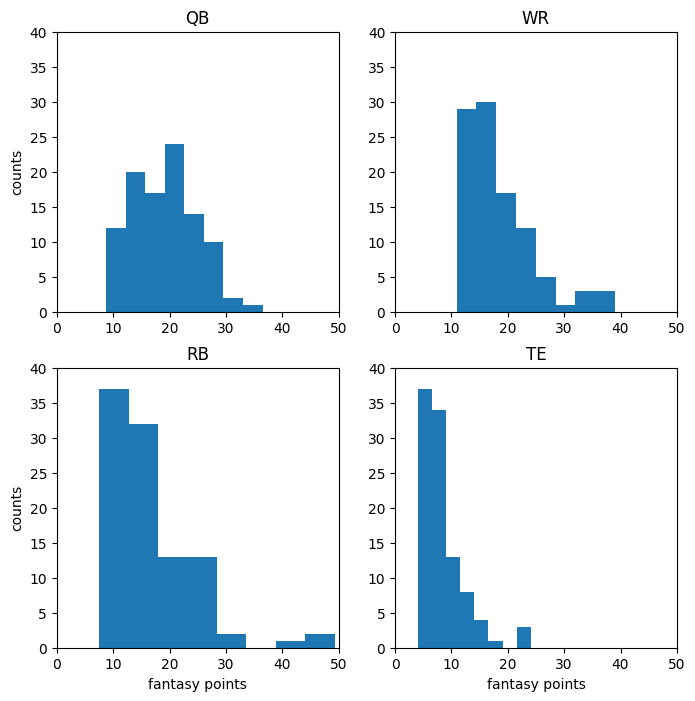

In [268]:
idx = 1
for df in [df_qb, df_wr, df_rb, df_te]:
    plt.subplot(2, 2, idx)
    
    plt.hist(df["Fan Pts"], bins = 8)
    plt.xlim(0, 50)
    plt.ylim(0, 40)
    
    if idx in (3, 4):
        plt.xlabel("fantasy points")
    if idx in (1, 3):
        plt.ylabel("counts")
    
    plt.gca().title.set_text(df.iloc[0, 2])
    
    idx += 1
plt.gcf().set_size_inches(8, 8)

Looking at the above subplot, we can see that all the plots are positively skewed (skewed to the right) although plot QB has the least skew, is the most centered. Plot TE seems to be condensed in the lower values while plot RB has the most range. All the plots are similar as they have the same shape.

# Part 4: Sketch and Begin Implementing a Pipeline

We wish to create a data frame that includes all the spells for each class (a "class" is something like a "wizard", or a "bard") in Dungeons and Dragons 5th Edition, which you can find [here](http://dnd5e.wikidot.com/). Your final data frame would look something like:

| Class     | Level     | Spell Name    | School      | Casting Time | Range                | Duration      | Components |
|----------:|----------:|--------------:|------------:|-------------:|---------------------:|--------------:|-----------:|
| Artificer | Cantrip   | Acid Splash   | Conjuration | 1 Action     | 60 Feet              | Instantaneous | V, S       |
| Artificer | Cantrip   | Booming Blade | Evocation   | 1 Action     | Self (5-foot radius) | 1 Round       | S, M       |
| ...       | ...       | ...           | ...         | ...          | ...                  | ...           | ...        |
| Wizard    | 9th Level | Wish          | Conjuration | 1 Action     | Self                 | Instantaneous | V          |

## Part 4.1: Poking Around (5 points)

Go to the D&D 5th Edition linked above. Scroll down to the "All Spells" list and click on "Artificer Spells", spend a moment looking around at the page, then "Bard Spells" to do the same, and make note of the url of each. What do you note about the pages and url that should be pretty convenient for scraping the data we are interested in for all different types of spells? Discuss anything else you might notice about the pages that may be either tricky or convenient to deal with. Note that in our desired data frame, we include the "Class" and "Level" for each spell.

It would be convenient to scrape the webpages for each class because each url only differs by the class name: for example, http://dnd5e.wikidot.com/spells:bard versus http://dnd5e.wikidot.com/spells:artificer. A simple f-string will work here. Since the tables on the pages are laid out simply, we should be able to use pd.read_html to read in the data. Adding "class" to the dataframe would require an additional step as it's not included in the table, as with "level". It may be tricky to add the "level" information seeing as the webpage has the data tables separated under different tags; depending on how pd.read_html reads in the each table on the page, it may be hard to distinguish which level goes with each table. I don't suppose the R for Ritual Spell will confuse anything.

## Part 4.2: Sketch the Pipeline (5 points)

First, in a markdown cell, write a bullet point list of tasks we need to get the data frame we want. I'll give you what the first bullet point should be, and you fill in the rest (there may be only one more, depending on how efficient you are in describing the tasks...):

- Write a function that takes a class (string) as an argument and returns the tables from the class's DND wiki spell page in a dictionary for each spell level
- ... 

Then, in a code cell, define **empty** functions that correspond to the tasks you identified as needing done. For example, the function for the first bullet point above might start with:

```python
def get_class_spell_dict(dnd_class):
    """ takes a D&D class (string) and gets the spell tables and saves them in a dictionary
    
    Args:
        dnd_class (str): the D&D class
        
    Returns:
        table_dict (dict): a dictionary of tables, one for each spell level
    """
    pass
```

   - Write a function that takes a class (string) as an argument and returns the tables from the class's DND wiki spell page in a dictionary for each spell level
   - A function that takes the dictionary with spell level mapped to table as an argument and returns a data frame that includes all the spells for each class

In [156]:
def create_spell_dataframe(table_dict):
    """ compiles all tables for each level in a class into a singular dataframe with all spells
    
    Args:
        table_dict (dict): a dictionary of tables, one for each spell level of a certain class
        
    Returns:
        df_dnd_spells (pd.DataFrame): a dataframe that includes all the spells for each class
    """
    pass

## Part 4.3: Write the first function (5 points)

Go ahead and write the first function that I defined the framework for in part 4.2, and then test it by getting the dictionary of Bard spell tables. Show that it works by printing out the head of the 2nd level Bard spells. Your final calls should be something like:

```python
bard_spell_tables = get_class_spell_dict("bard")
bard_spell_tables['Level 2'].head()
```

**Note**: depending on how you create the dictionary in your `get_class_spell_dict` function, you may not have `'Level 2'` as the key; that's fine. The top of the table should look like:

| Spell Name       | School        | Casting Time | Range                | Duration      | Components |
|-----------------:|--------------:|-------------:|---------------------:|--------------:|-----------:|
| Aid              | Abjuration    | 1 Action     | 30 Feet              | 8 hours       | V, S, M    |
| Animal Messenger | Enchantment   | 1 Action R   | 30 Feet              | 24 hours      | V, S, M    |

In [163]:
def get_class_spell_dict(dnd_class):
    """ takes a D&D class (string) and gets the spell tables and saves them in a dictionary
    
    Args:
        dnd_class (str): the D&D class
        
    Returns:
        table_dict (dict): a dictionary of tables, one for each spell level
    """
    url = f"http://dnd5e.wikidot.com/spells:{dnd_class}"
    table = pd.read_html(url)
    
    table_dict = dict({})
    
    i = 0
    while i in range(len(table)):
        if i == 0:
            table_dict["Cantrip"] = table[i]
        else:
            label = f"Level {i}"
            table_dict[label] = table[i]
        i += 1
    
    return table_dict

In [164]:
bard_spell_tables = get_class_spell_dict("bard")
bard_spell_tables['Level 2'].head()

,Spell Name,School,Casting Time,Range,Duration,Components
0,Aid,Abjuration,1 Action,30 Feet,8 hours,"V, S, M"
1,Animal Messenger,Enchantment,1 Action R,30 Feet,24 hours,"V, S, M"
2,Blindness/Deafness,Necromancy,1 Action,30 Feet,1 minute,V
3,Borrowed Knowledge,Divination,1 Action,Self,1 hour,"V, S, M"
4,Calm Emotions,Enchantment,1 Action,60 feet,"Concentration, up to 1 minute","V, S"
